# Libraries

In [93]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(rc = {'figure.figsize':(15,8)})

# Data import and cleaning

In [89]:
def loadRawData():
    # Loading each csv into the list and concat them into one dataframe in one step 
    df = []

    for file in os.listdir('data'):
        temp = pd.read_csv(
            f'data/{file}', 
            parse_dates = {'date': ['year', 'month', 'day', 'hour']}, 
            date_parser = lambda x: datetime.strptime(x, '%Y %m %d %H'),
            keep_date_col = True # will be used as dummies
        )

        # Values for different stations in each city are simmilar, so we can take the mean of them 
        targetCols = [col for col in temp.columns if 'PM' in col]
        temp['meanPM'] = temp[targetCols].mean(axis=1).round(2)

        # Just a 1-indexed column, we don't need it
        targetCols.append('No')
        temp.drop(targetCols, axis=1, inplace=True)

        # Adding the source of the data from the filename
        temp['source'] = file.split('PM')[0]
        df.append(temp)

    df = pd.concat(df, axis = 0).reset_index(drop = True)

    # Moving important columns to the front, will be usefull when categorical columns are converted to dummies
    colsToMove = ['date', 'source', 'meanPM']
    df = df[colsToMove + [col for col in df.columns if col not in colsToMove]]
    df['dayOfWeek'] = df['date'].dt.dayofweek
    
    return df

In [90]:
df = loadRawData()
df

,date,source,meanPM,year,month,day,hour,season,DEWP,HUMI,PRES,TEMP,cbwd,Iws,precipitation,Iprec,dayOfWeek
0,2010-01-01 00:00:00,Beijing,NaN,2010,1,1,0,4.0,-21.0,43.00,1021.0,-11.0,NW,1.79,0.0,0.0,4
1,2010-01-01 01:00:00,Beijing,NaN,2010,1,1,1,4.0,-21.0,47.00,1020.0,-12.0,NW,4.92,0.0,0.0,4
2,2010-01-01 02:00:00,Beijing,NaN,2010,1,1,2,4.0,-21.0,43.00,1019.0,-11.0,NW,6.71,0.0,0.0,4
3,2010-01-01 03:00:00,Beijing,NaN,2010,1,1,3,4.0,-21.0,55.00,1019.0,-14.0,NW,9.84,0.0,0.0,4
4,2010-01-01 04:00:00,Beijing,NaN,2010,1,1,4,4.0,-20.0,51.00,1018.0,-12.0,NW,12.97,0.0,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262915,2015-12-31 19:00:00,Shenyang,254.33,2015,12,31,19,4.0,-10.0,92.42,1031.0,-9.0,SE,2.00,0.0,0.0,3
262916,2015-12-31 20:00:00,Shenyang,314.33,2015,12,31,20,4.0,-10.0,79.10,1030.0,-7.0,SE,5.00,0.0,0.0,3
262917,2015-12-31 21:00:00,Shenyang,331.67,2015,12,31,21,4.0,-10.0,79.10,1030.0,-7.0,SE,8.00,0.0,0.0,3
262918,2015-12-31 22:00:00,Shenyang,287.67,2015,12,31,22,4.0,-10.0,79.10,1028.0,-7.0,SE,11.00,NaN,NaN,3


# EDA

### Dependent variable as is

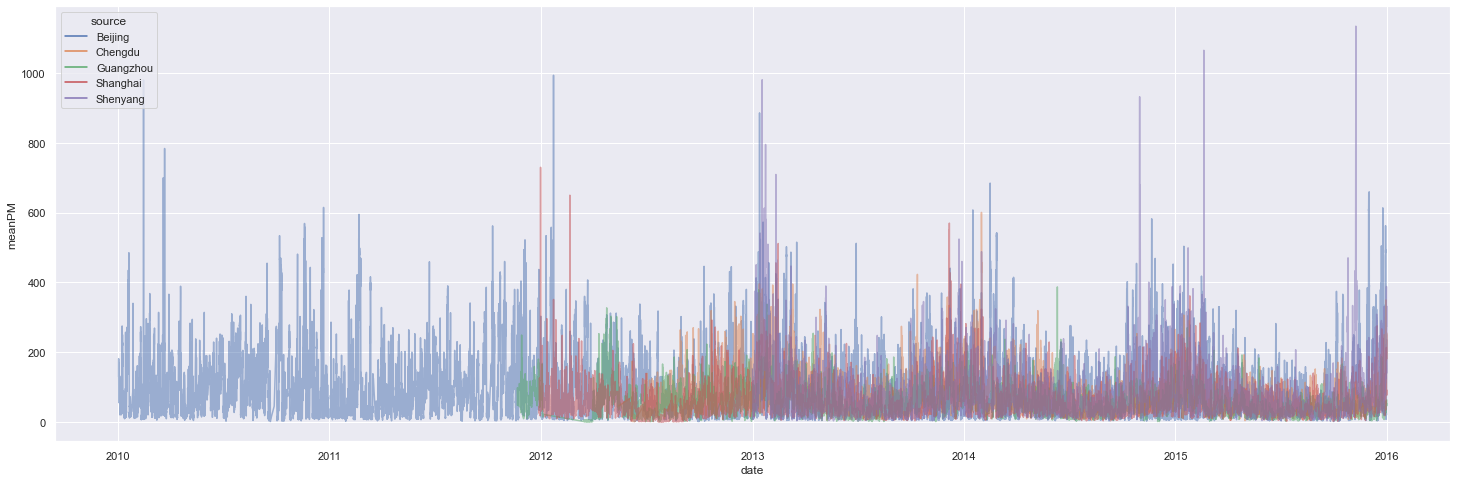

In [76]:
sns.set(rc = {'figure.figsize':(25, 8)})

sns.lineplot(data = df, x = 'date', y = 'meanPM', hue = 'source', alpha = 0.5)

sns.set(rc = {'figure.figsize':(15,8)})

### Removed 24h seasonality

c:\Users\micha\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


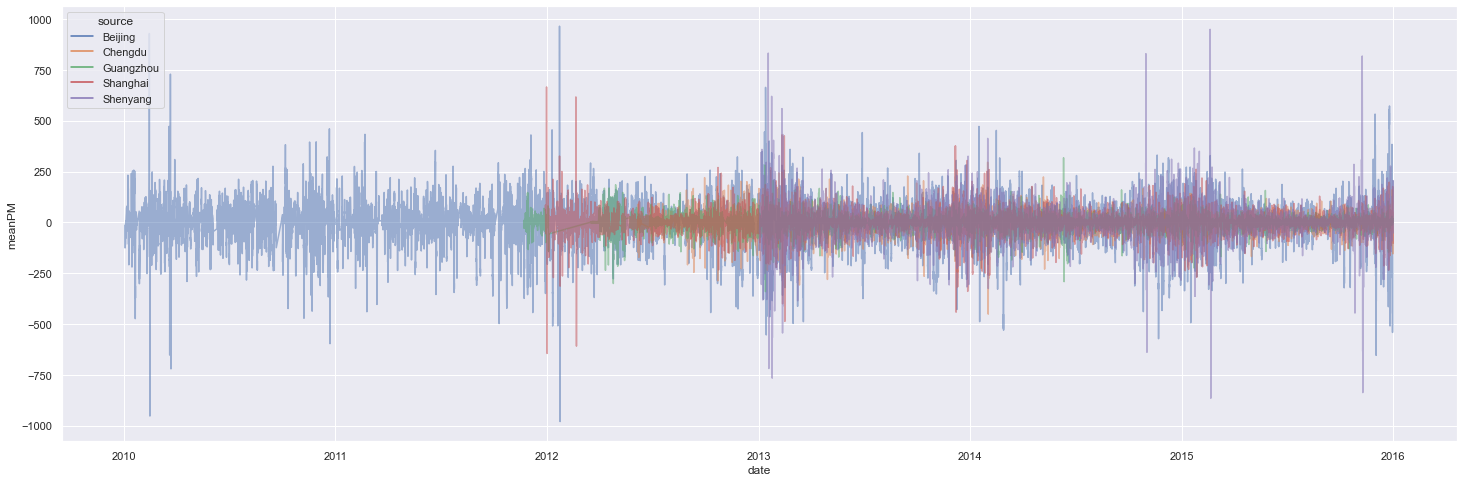

In [77]:
sns.set(rc = {'figure.figsize':(25, 8)})
sns.lineplot(df.date, (df.meanPM - df.meanPM.shift(24)), hue = df.source, alpha = 0.5)
sns.set(rc = {'figure.figsize':(15,8)})

### Exploring the seasonality

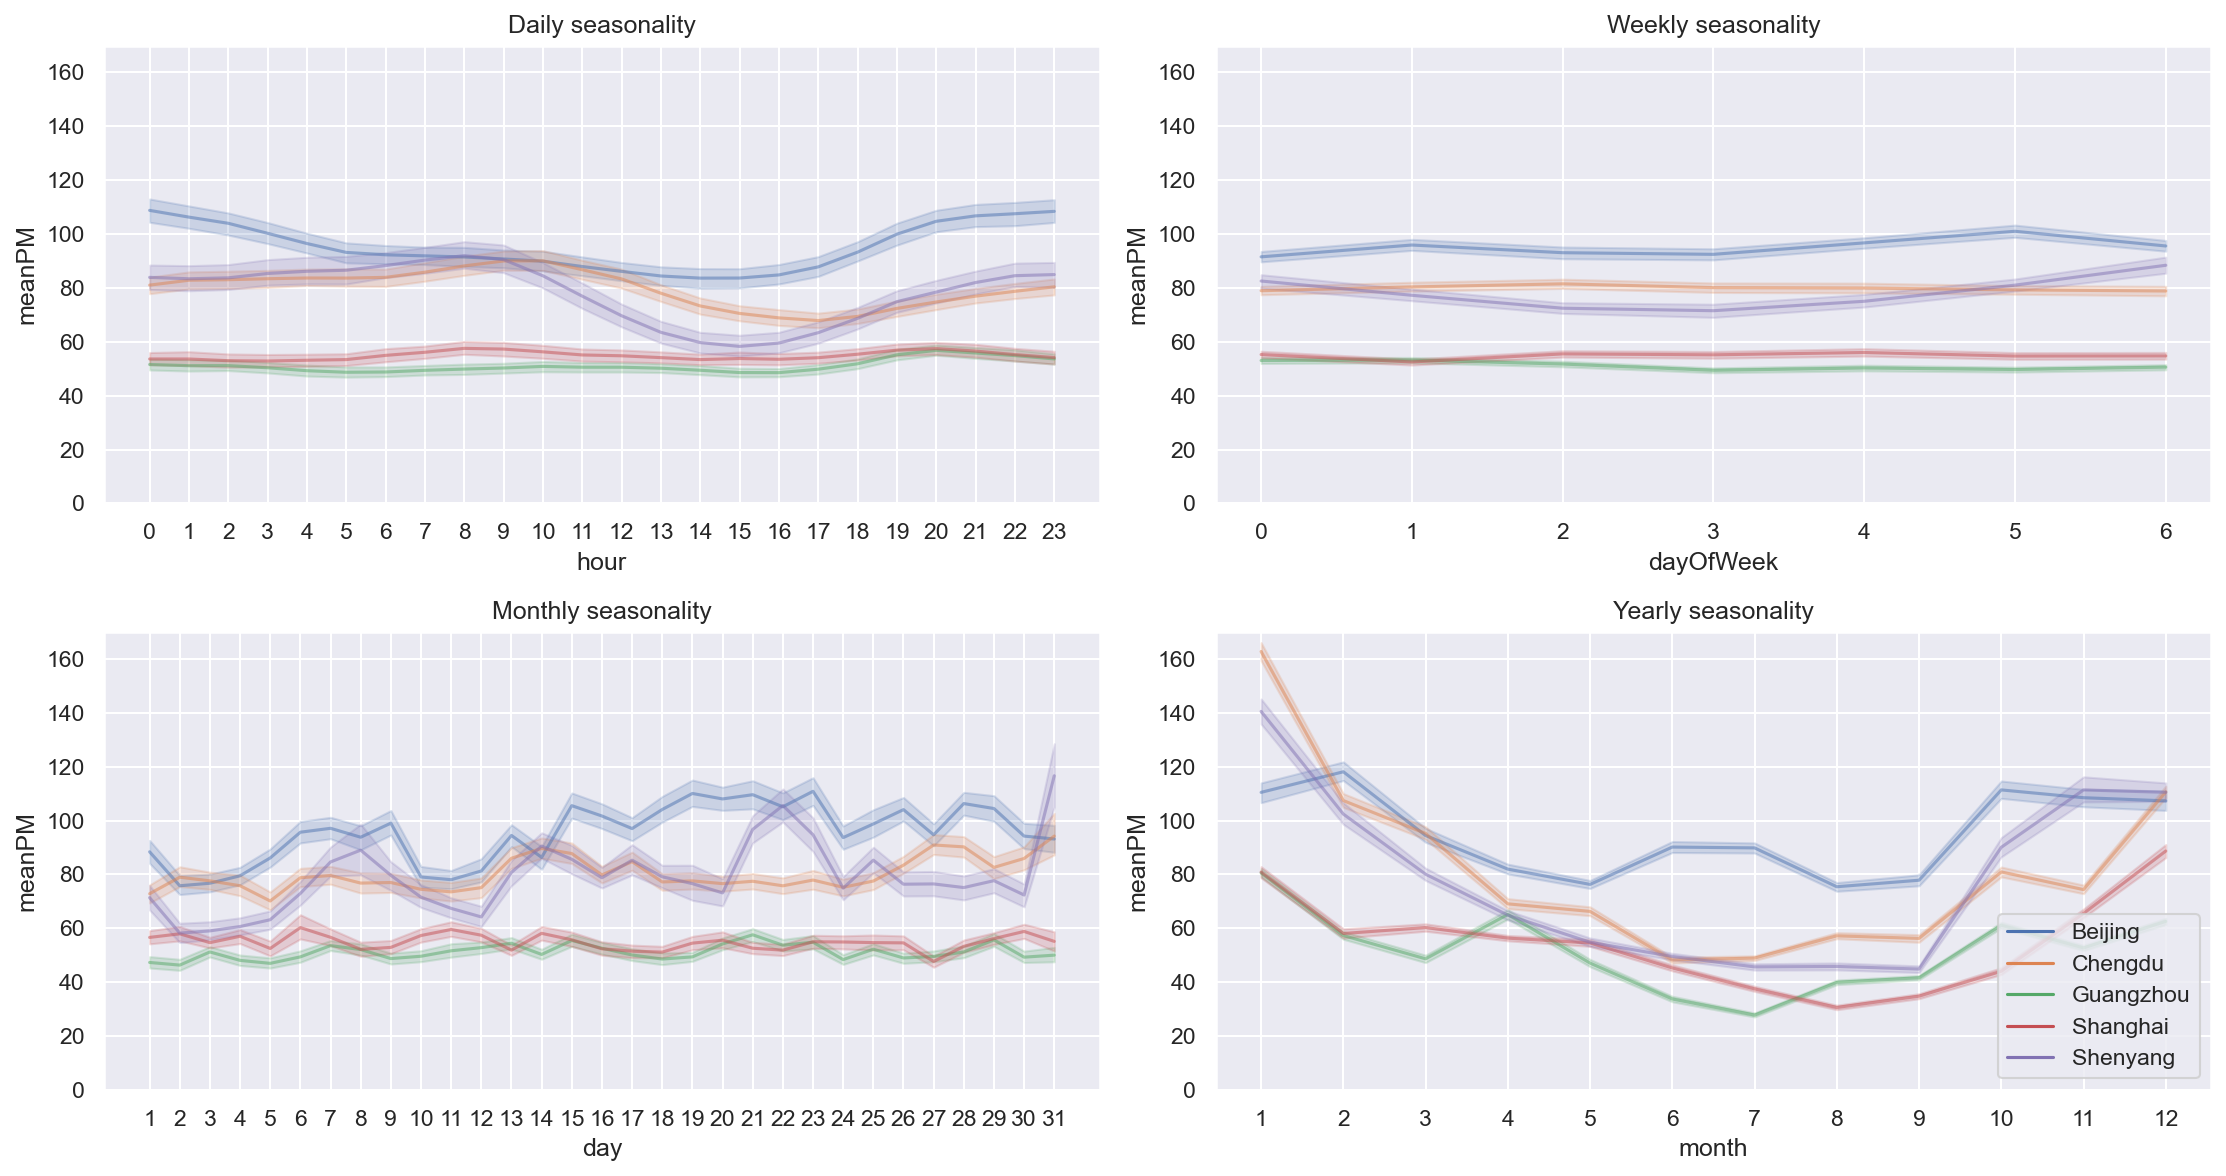

In [124]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 8), dpi = 150)

seasonality = {
    'hour' : 'Daily seasonality',
    'dayOfWeek' : 'Weekly seasonality',
    'day' : 'Monthly seasonality',
    'month' : 'Yearly seasonality', 
}

for i, (col, title) in enumerate(seasonality.items()):
    sns.lineplot(data = df, x = col, y = 'meanPM', hue = 'source', alpha = 0.5, ax = axs[i//2, i%2]).set(title = title, ylim = (0, 170))
        
handles, labels = axs[1, 1].get_legend_handles_labels()

[[c.get_legend().remove() for c in r] for r in axs]

fig.tight_layout()

plt.legend(handles, labels, loc = 'lower right', bbox_to_anchor = (1, 0))